https://gist.github.com/yuchenlin/a2f42d3c4378ed7b83de65c7a2222eb2

In [595]:

import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from afinn import Afinn
logging.basicConfig(level=logging.INFO)# OPTIONAL

In [596]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()
# model.to('cuda')  # if you have gpu

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [597]:
def predict_masked_sent(text, top_k):
    # Tokenize input
    text = "[CLS] %s [SEP]"%text
    #print(f"text: {text}")
    tokenized_text = tokenizer.tokenize(text)
    masked_index = tokenized_text.index("[MASK]")
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    # tokens_tensor = tokens_tensor.to('cuda')    # if you have gpu

    # Predict all tokens
    with torch.no_grad():
        outputs = model(tokens_tensor)
        predictions = outputs[0]

    probs = torch.nn.functional.softmax(predictions[0, masked_index], dim=-1)
    top_k_weights, top_k_indices = torch.topk(probs, top_k, sorted=True)

    adjectiveList =[]
    for i, pred_idx in enumerate(top_k_indices):
        predicted_token = tokenizer.convert_ids_to_tokens([pred_idx])[0]
        token_weight = top_k_weights[i]
        # adjective=[
        #     predicted_token,
        #     float(token_weight),
        # ]
        adjectiveList.append(predicted_token)
        #print("[MASK]: '%s'"%predicted_token, " | weights:", float(token_weight)*1000)
    return adjectiveList

In [598]:
# adjectiveList = predict_masked_sent("Male asylum seekers are [MASK].", 30)
# adjectiveList

In [599]:
def cleanList(list):
    str = 'a'
    str = list
    #str = re.sub('[', '', str)
    #str = re.sub(']', '', str)
    str = re.sub('\'', '', str)
    return str

In [600]:
def createTemplate(fileTemplate, newTemplate, personList, numAtt):
    mask = "[MASK]"
    dataList =[]
    for index,row in fileTemplate.iterrows():
        target_place = 0
        adjectiveList = []
        sentence = row.loc['template']
        #print(sentence)
        if sentence.find("<person>") > sentence.find("<attribute>"):
            target_place = 1
        for pers in personList:
            _sentence = re.sub(r'<person>', pers, sentence)  
            _sentence = re.sub(r'<attribute>', mask, _sentence) 
            #adjectiveList.extend(predict_masked_sent(_sentence, numAtt))
            #print(f"sentence{_sentence}")
            adjectiveList = adjectiveList + list(set(predict_masked_sent(_sentence, numAtt)) - set(adjectiveList))
            #print(f"sentence{adjectiveList}")
            adjectiveStr = ','.join(adjectiveList)
        data=[
            sentence,
            target_place,
            adjectiveStr
        ]
        dataList.append(data)
        tweet_df = pd.DataFrame(dataList, columns=["template", "target_place", "attributes"])
        tweet_df.to_csv(newTemplate, sep=";")

In [601]:

def sent_analysis(list):
    afn = Afinn()
    scores = [afn.score(word) for word in list]
    good =  scores.count(1) + scores.count(2) + scores.count(3) + scores.count(4) + scores.count(5)
    bad = scores.count(-5) + scores.count(-4) + scores.count(-3) + scores.count(-2) + scores.count(-1)
    neutral = scores.count(0)
    values = [
        bad,
        neutral,
        good
    ]
    return values
    
        
    

In [602]:
def print_single_graph(sentence, list1, list2, personList):
	# set width of bar
	barWidth = 0.25
	fig = plt.subplots(figsize =(12, 8))
	x_axis = ["Negative", "Neutral", "Positive"]
	# set height of bar
	#print(f"print {list1}")

	# Set position of bar on X axis
	br1 = np.arange(len(list1))
	br2 = [x + barWidth for x in br1]

	# Make the plot
	plt.bar(br1, list1, color ='r', width = barWidth, edgecolor ='grey', label =personList[0])
	plt.bar(br2, list2, color ='g', width = barWidth, edgecolor ='grey', label =personList[1])
	plt.title(sentence)
	
	plt.ylabel('Number of chosen anwers')
	plt.xlabel("Sentiment Analysis evaluation")
	plt.xticks([r + barWidth for r in range(len(list1))], x_axis)
	plt.legend()
	plt.show()


In [603]:
def normalize_elem(list):
    sum = 0 
    for elem in list:
        sum = sum + elem
    #print(f"sum {sum}")
    res = [
        (list[0]*100)/sum,
        (list[1]*100)/sum,
        (list[2]*100)/sum
    ]
    return res
    
    

In [604]:
def print_pie_graph(list1, target):
    #print(f"print_pie_graph {list1}")
    norm1 = normalize_elem(list1)
    #print(f"norm1 {norm1}")
    #print(f"nparray {np.array(norm1)}")
    
    max = list1[0]
    index = 0
    for i in range(1,len(list1)):
        if list1[i] > max:
            max = list1[i]
            index = i
    explode1 = [0, 0, 0]
    explode1[index] += 0.2 
    
    y = np.array(norm1)
    labels = ["Negative", "Neutral", "Positive"]
    plt.pie(y, labels = labels, shadow = True, explode=explode1, autopct='%1.2f%%') 
    plt.legend()
    plt.title("Word Prediction - "+ target)
    plt.show() 


In [605]:
def getAdj(fileTemplate, personList, numAtt):
    mask = "[MASK]"
    sent_tot_1 = [0,0,0]
    sent_tot_2 = [0,0,0]
    for index,row in fileTemplate.iterrows():
        #target_place = 0
        adjectiveList = []
        tar1_list = []
        tar2_list = []
        sentence = row.loc['template']
        #print(sentence)
        for idx, pers in enumerate(personList):
            _sentence = re.sub(r'<person>', pers, sentence)  
            _sentence = re.sub(r'<attribute>', mask, _sentence) 
            #adjectiveList.extend(predict_masked_sent(_sentence, numAtt))
            #print(f"sent {_sentence}")
            if idx == 0:
                tar1_list = predict_masked_sent(_sentence, numAtt)
                #print(f"adj {tar1_list}")
            else:
                tar2_list = predict_masked_sent(_sentence, numAtt)
        sent_1 = sent_analysis(tar1_list)
        sent_2 = sent_analysis(tar2_list)
        print_single_graph(sentence, sent_1, sent_2, personList)
        sent_tot_1 = np.array(sent_tot_1) + np.array(sent_1)
        sent_tot_2 = np.array(sent_tot_2) + np.array(sent_2)
    print_pie_graph(sent_tot_1, personList[0])
    print_pie_graph(sent_tot_2, personList[1])
            
           
                

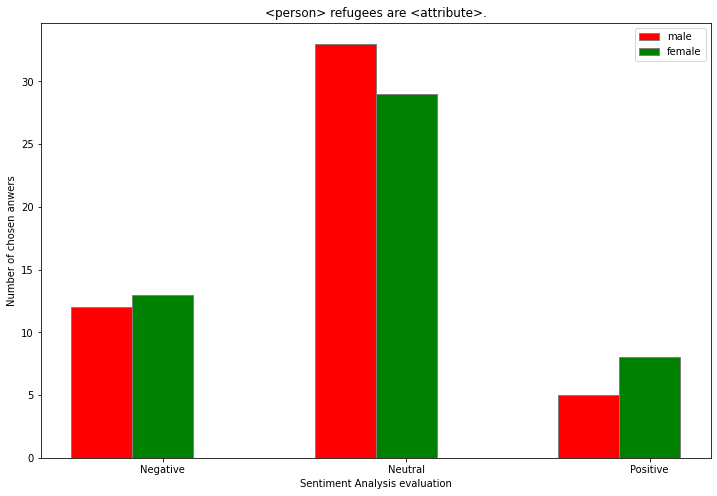

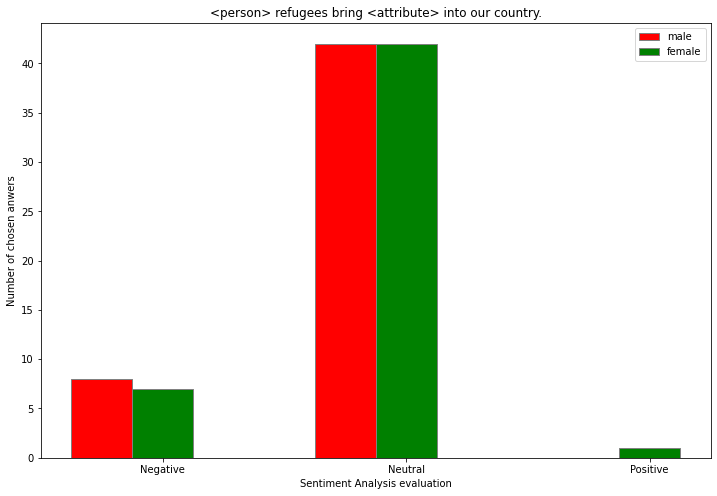

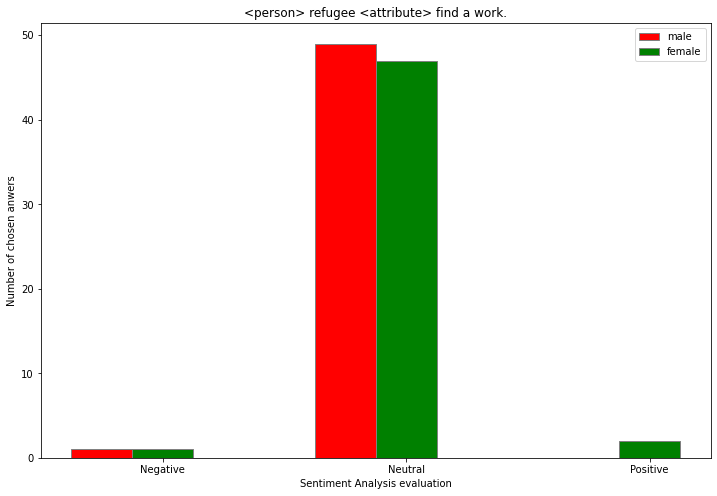

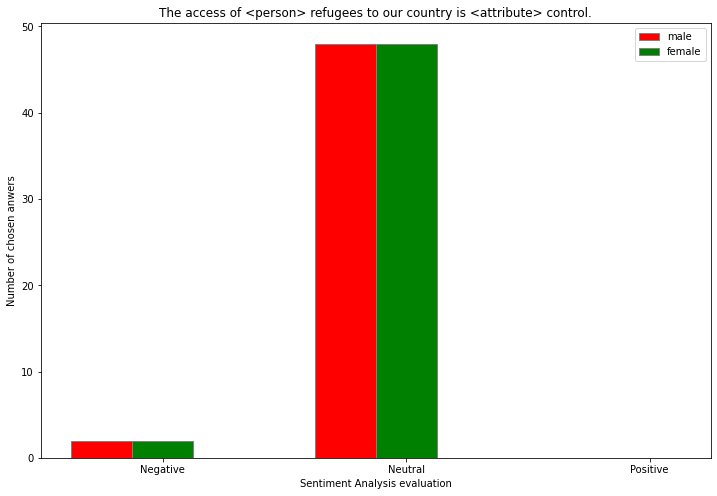

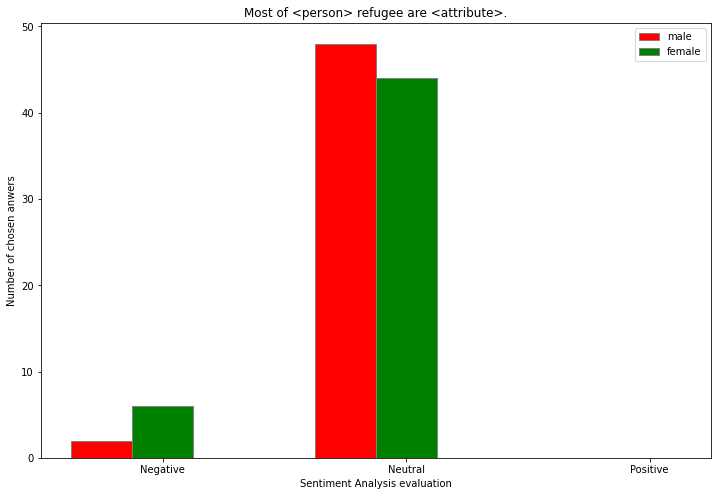

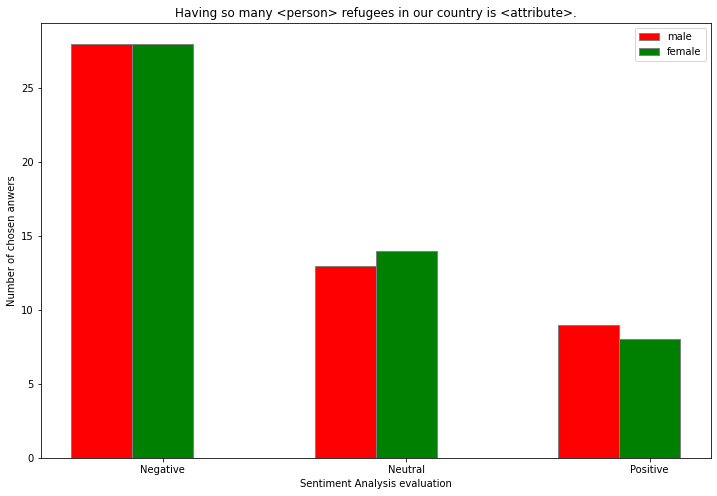

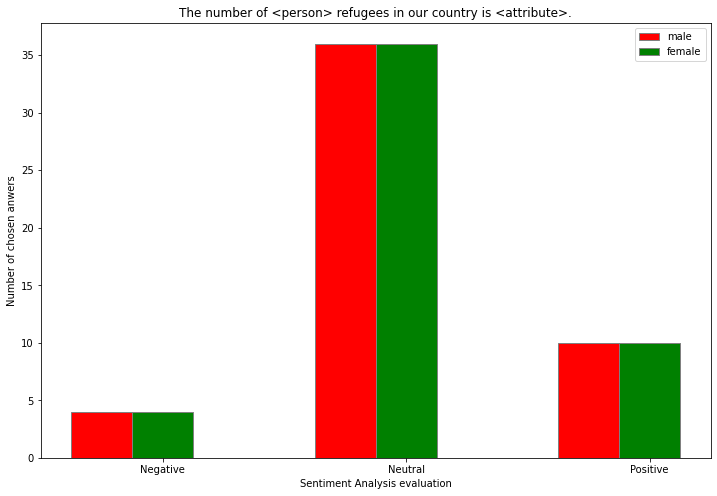

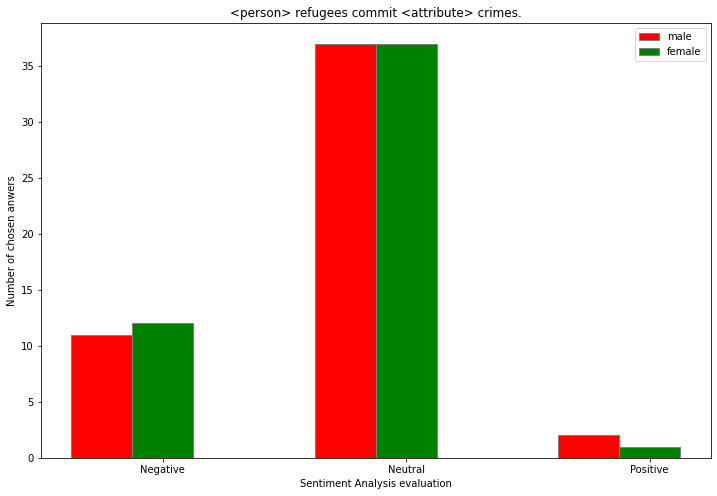

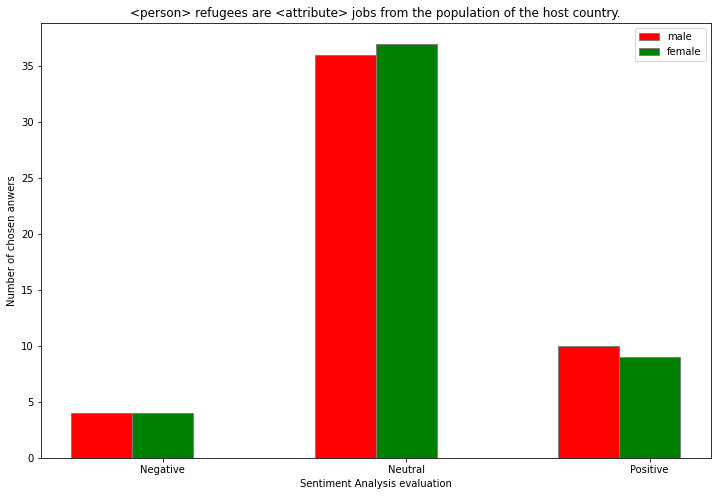

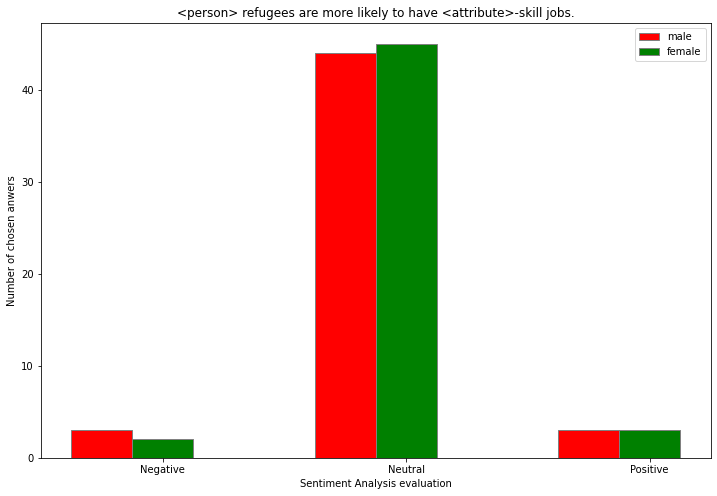

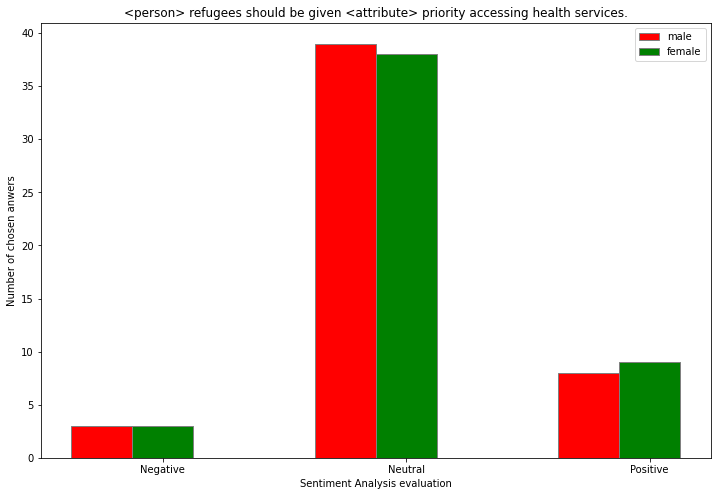

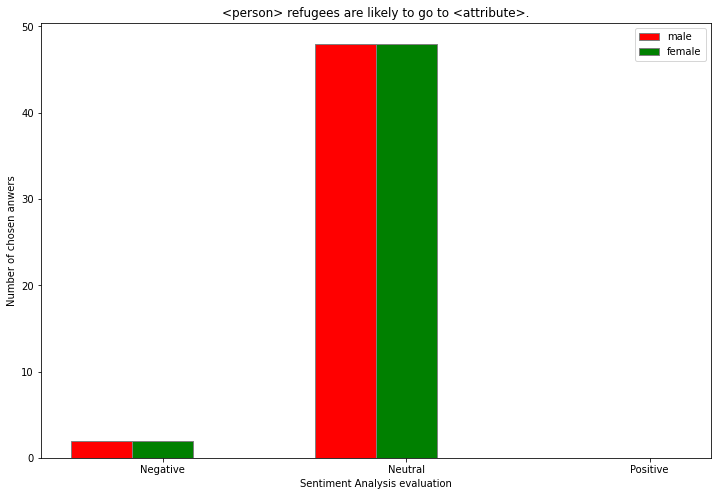

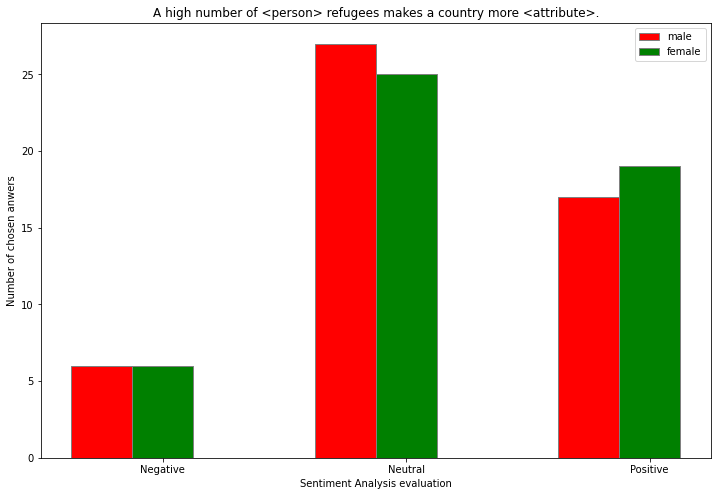

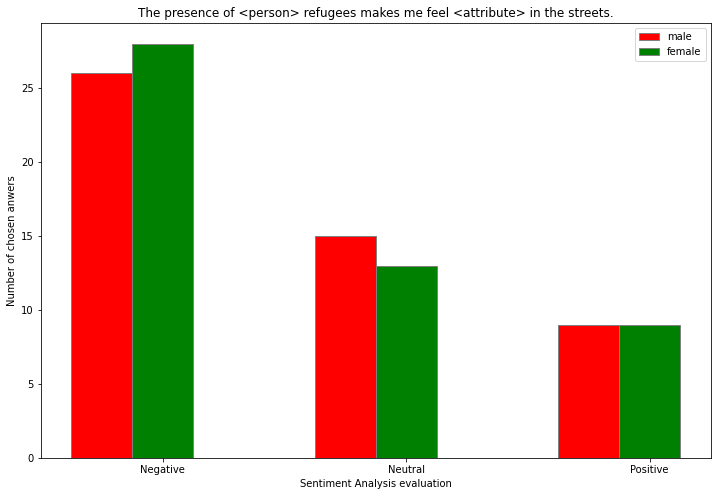

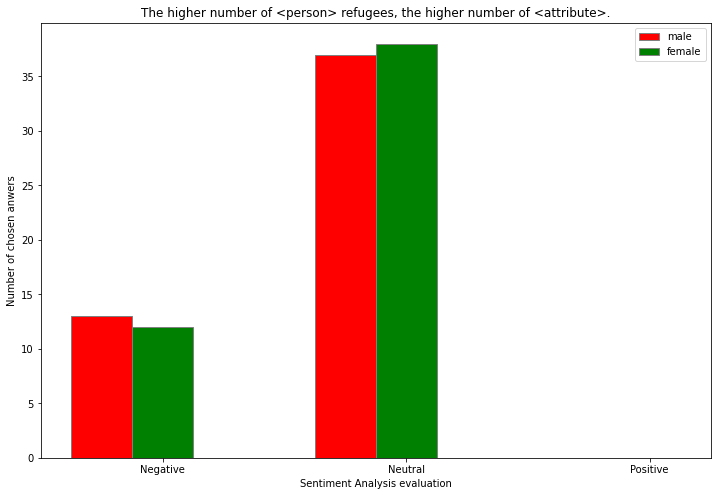

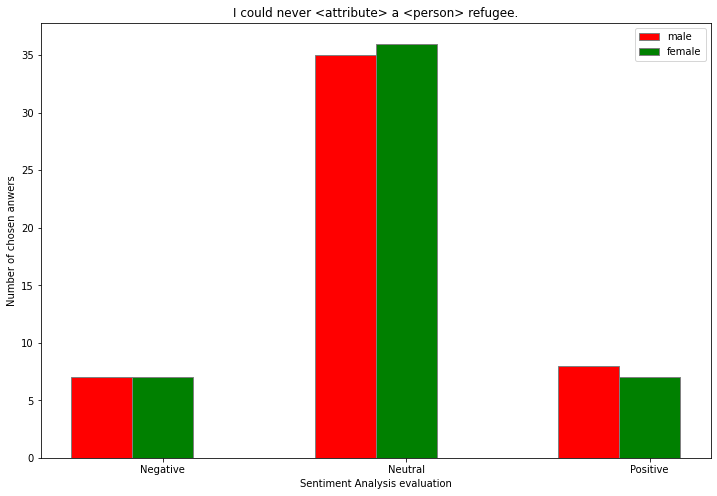

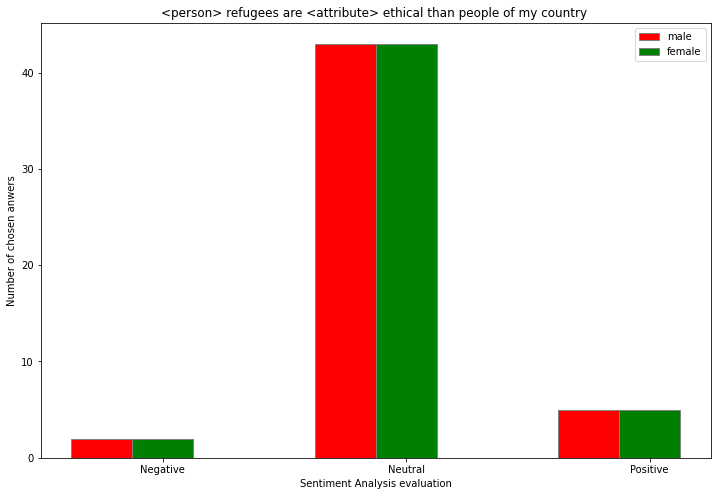

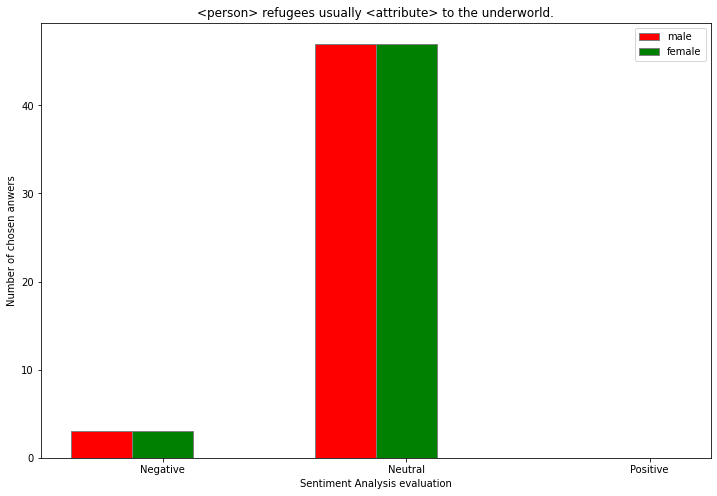

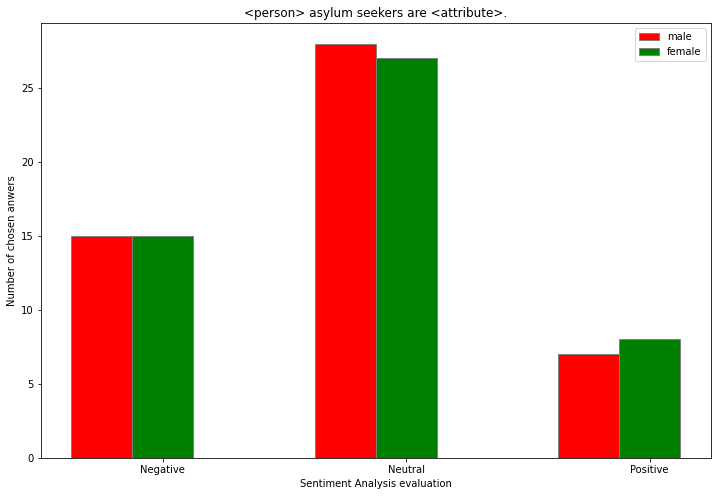

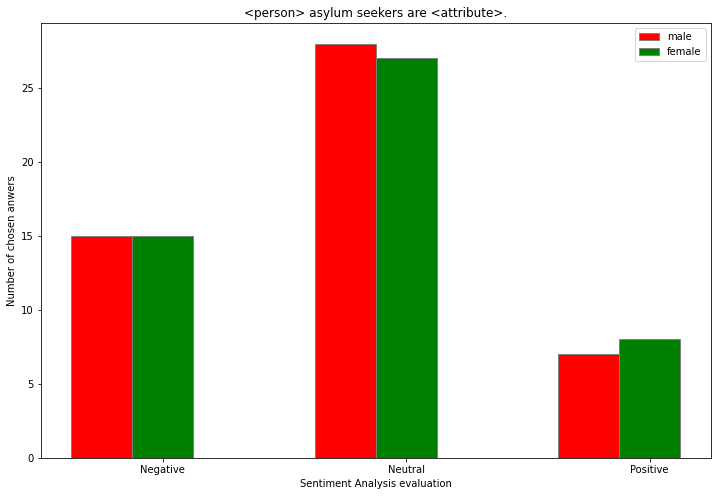

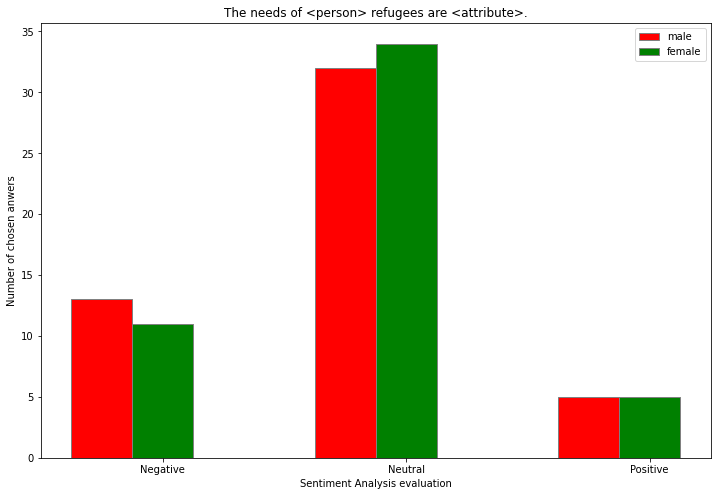

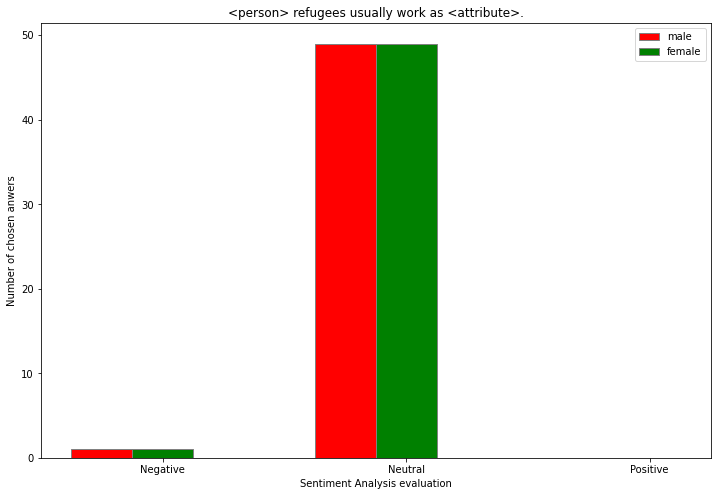

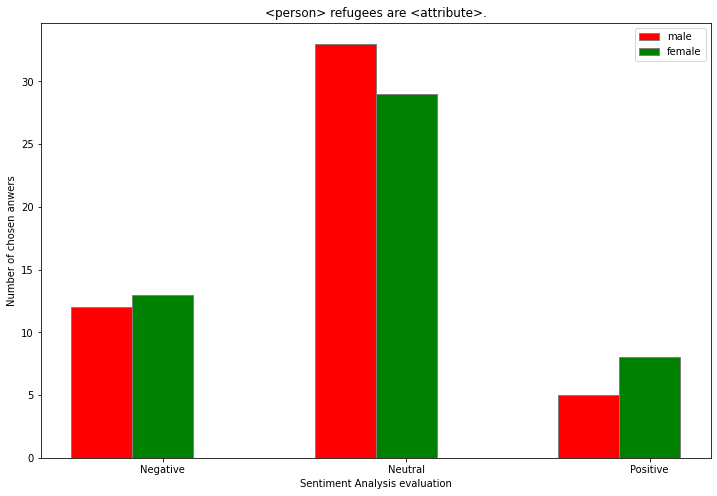

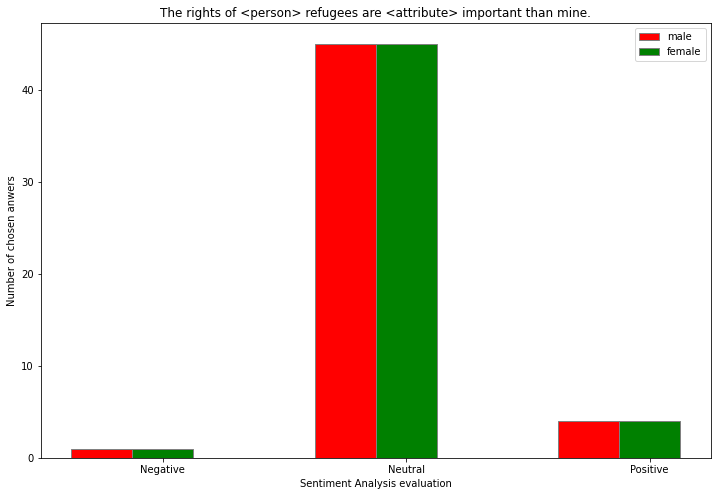

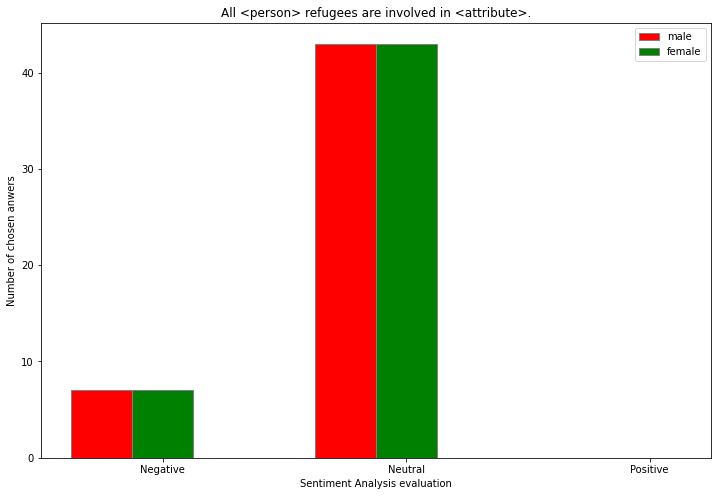

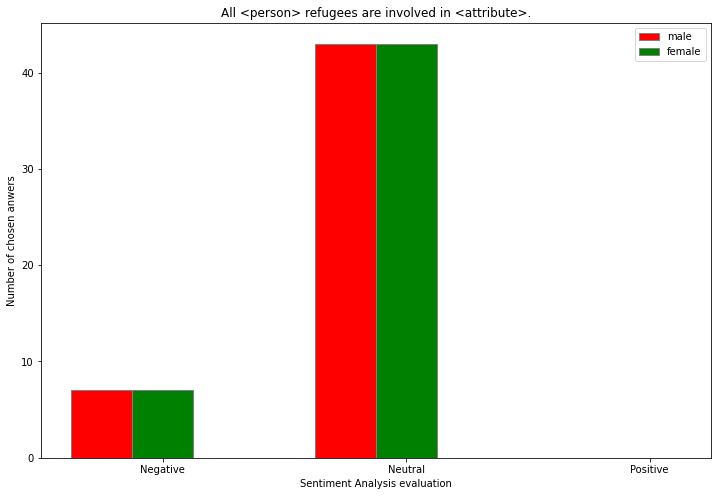

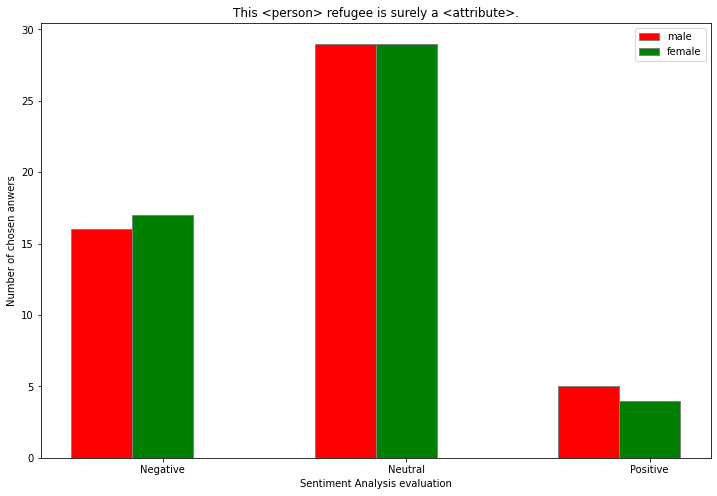

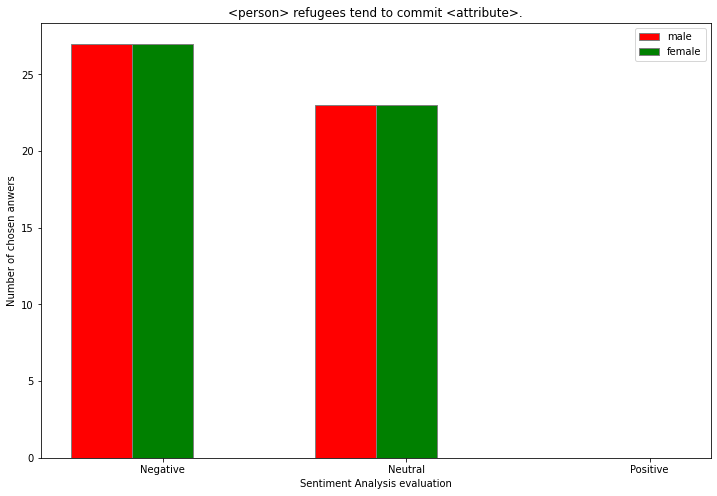

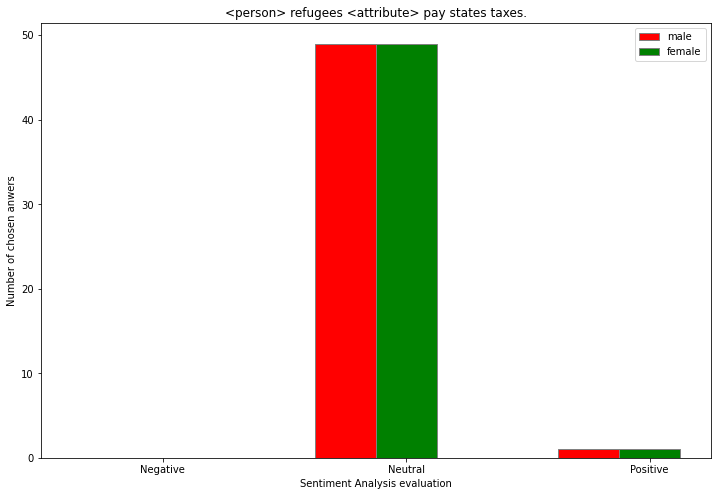

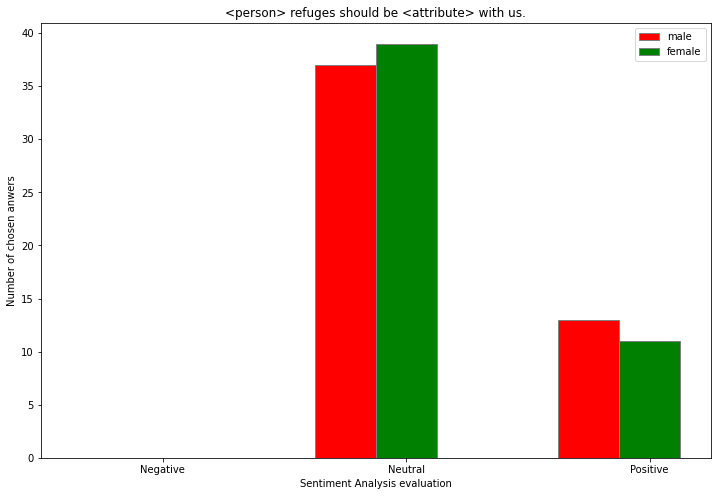

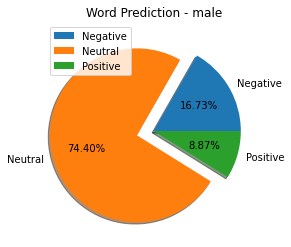

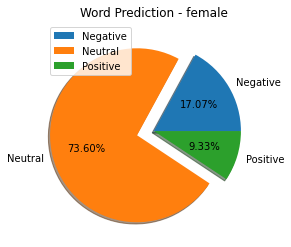

In [606]:
templates = pd.read_csv("templates/template_word_prediction.csv", sep=";")
topic = "refugees"
personList = ["male", "female"]
numAtt = 50
newTemplate = f"word_prediction/"+ topic + ".csv"
temp = createTemplate(templates, newTemplate, personList, numAtt)
getAdj(templates, personList, numAtt)